## Compute forecast metrics using item-level backtests

<b>DC Bikeshare Rentals data</b>

Our goal is to predict the number of DC Bikeshare rentals in the next 24 hours for each of 467 rental locations.  To do this, we used Amazon Forecast to create forecasts with 1 hour frequency and 1 week forecast horizon.   
<ul>
    <li>See <a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/, target='_blank' ">blog post for screens how the forecast was created.</a></li>
<li>Original data source: <a href="https://www.capitalbikeshare.com/system-data", target='_blank'"> https://www.capitalbikeshare.com/system-data</a> </li>
    </ul>  

This notebook picks up after the blog post Predictor has been trained.  In the overall Amazon Forecast workflow, this notebook covers <i>step 6. Inspect the model using the backtest window forecasts, see context below.</i>
<br><br>


<b>Overall process for using Amazon Forecast:</b>

![alt text](images/forecast_steps_overview.png "Title")

<ol>
    <li>Prepare your data and save up to 3 separate .csv files.  In Forecast there are  3 types of Datasets (Target, Related, and Meta data). <br>
        <ul>
        <li>The Target Time Series is required, it is the historical values of what you're trying to predict, i.e. historical y-values or target values.  The others provide additional context with certain algorithms. <br>
        </ul><br>
    <li>Per dataset, you will specify the schema. </li>
    <li>Per dataset, create a Data Import Job. Give the S3 location where data will be read from. </li>
    <li>Create a Dataset Group.  This is a container that groups together your models, data they are trained on, and forecasts.  <br>
        <ul>
            <li>Having this grouping is convenient if in the future, you want to look up artifacts how you ran a particular forecast. </li>
        <li>The Dataset Group is also how you can run inferences (forecasts) in the future, without retraining, just by importing new data, by creating a new Data Import job.  </li>
        </ul><br>
    <li>Train a model.  Amazon Forecast offers AutoML to do this process for you, but you can also select a particular algorithm (6 built-in algorithms).  AutoML will do Hyper Parameter Optimization(HPO) to determine the most performant values automatically, or you can select your own values.</li>
    <b><li>Inspect the model using the backtest window forecasts. This notebook focuses on this step.</li>
    <ul>
    <li>We will use the built-in feature of Amazon Forecast that exports backtest window forecasts together with actuals, for Predictor analysis.  </li>
    <li>Predictor evaluation is recommended to make an informed decision whether to deploy the current Predictor to make Forecasts, or whether to fix something in the data setup and train a new Predictor. </li></b>
    </ul><br>
    <li>Deploy the model (or create a forecast).  Here you are deploying your model so you can use it to do inferences (or generate forecasts).</li>
    <li>Query and visualize the Forecast (available in console UI). Spot-check actual values and forecasted values at different quantiles in the console for a particular itemID. The visualization feature in the console is basic, not user-interactive.  For more advanced visualizations, consider exporting your forecasts to an S3 location and point your BI tool (e.g. Tableau or Quicksight) to that data.</li>
    </ol>
<br>


<b>Table Of Contents for task of inspecting the model using the backtest window forecasts</b>
* [Set up and install libraries](#setup)
* [Export predictor backtests](#export)
* [Assemble and read predictor backtest files](#read)
* [Demo using item-level forecast files](#demo)
* [Calculate custom metric MAPE](#mape)
* [Calculate another custom metric log(RMSE)](#logrmse)
* [Visualizations of backtest windows](#visualizations)

<br>

## Set up  <a class="anchor" id="setup"></a>
Import Python and aws libraries


In [7]:
import sys
import os
# import time
# import datetime
import random
import pprint
pp = pprint.PrettyPrinter(indent=2)  # Better display for dictionaries

# display ipython widgets in notebook
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

import pandas as pd
print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display all rows long
pd.set_option('display.max_rows', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
print('numpy: {}'.format(np.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 


# Python library for AWS APIs
import boto3

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("../../common") )
import util

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
pandas: 1.0.5
numpy: 1.19.1


In [103]:
### TODO delete later
# util doesn't exist so create locally
import ipywidgets


widget_table = {}

def create_text_widget( name, placeholder, default_value="" ):
    
    layout = ipywidgets.Layout(horz="top", object_fit="scale-down"
                               , width='auto'
                               , display="flex"
                              ) 

    if name in widget_table:
        widget = widget_table[name]
    if name not in widget_table:
        widget = ipywidgets.Text( description = name, placeholder = placeholder
                                 , value=default_value 
                                 , layout = layout)
        widget_table[name] = widget
    display(widget)
    
    return widget



class StatusIndicator:
    
    def __init__(self):
        self.previous_status = None
        self.need_newline = False
        
    def update( self, status ):
        if self.previous_status != status:
            if self.need_newline:
                sys.stdout.write("\n")
            sys.stdout.write( status + " ")
            self.need_newline = True
            self.previous_status = status
        else:
            sys.stdout.write(".")
            self.need_newline = True
        sys.stdout.flush()

    def end(self):
        if self.need_newline:
            sys.stdout.write("\n")


In [ ]:
def get_velocity_per_item(df, timestamp_col, item_id_col="item_id"):
    """Calculate item velocity as item demand per hour.  
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], format='%Y-%m-%d %H:%M:%S')
    
    max_time_df = df.groupby([item_id_col], as_index=False).max()[[item_id_col, timestamp_col]]
    max_time_df.columns = [item_id_col, 'max_time']
    
    min_time_df = df.groupby([item_id_col], as_index=False).min()[[item_id_col, timestamp_col]]
    min_time_df.columns = [item_id_col, 'min_time']
    
    df = df.merge(right=max_time_df, on=item_id_col)
    df = df.merge(right=min_time_df, on=item_id_col)
    
    df['time_span'] = df['max_time'] - df['min_time']
    df['time_span'] = df['time_span'].apply(lambda x: x.seconds / 3600 + 1) # add 1 to include start datetime and end datetime
    df = df.groupby([item_id_col], as_index=False).agg({'time_span':'mean', 'target_value':'sum'})
    df['velocity'] = df['target_value'] / df['time_span']
    return df


# based on all available records, could beyond 4 windows
def get_fast_slow_moving_items_all(gt_df
                                   , timestamp_col
                                   , target_value_col
                                   , item_id_col="item_id"):
    """Calculate mean velocity over all items as "criteria".
       Assign each item into category "fast" or "slow" depending on whether its velocity > criteria.
    """
    gt_df_velocity = gt_df[[item_id_col, timestamp_col, target_value_col]].copy().reset_index(drop=True)
    gt_df_velocity = get_velocity_per_item(gt_df_velocity, timestamp_col, item_id_col)
    criteria = gt_df_velocity['velocity'].mean()
    gt_df_velocity['fast_moving'] = gt_df_velocity['velocity'] > criteria
    print('average velocity of all items:', criteria)
    
    fast_moving_items = gt_df_velocity[gt_df_velocity['fast_moving'] == True][item_id_col].to_list()
    slow_moving_items = gt_df_velocity[gt_df_velocity['fast_moving'] == False][item_id_col].to_list()
    return fast_moving_items, slow_moving_items

In order to run Amazon Forecast, you'll need an AWS account.  
<b>Make sure you can log in to: https://console.aws.amazon.com/.  </b>  Then read each cell carefully and execute the cells in this notebook.
<br>
<br>

<b>Configure the S3 bucket name and region name for this lesson.</b>

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [104]:

# text_widget_bucket = util.create_text_widget( "bucket_name", "input your S3 bucket name"
#                                              , default_value="bike-demo" )
# text_widget_region = util.create_text_widget( "region", "input region name."
#                                              , default_value="us-west-2" )

# TODO delete this and put above back
text_widget_bucket = create_text_widget( "bucket_name", "input your S3 bucket name"
                                             , default_value="bike-demo" )
text_widget_region = create_text_widget( "region", "input region name."
                                             , default_value="us-west-2" )

Text(value='bike-demo', description='bucket_name', layout=Layout(display='flex', object_fit='scale-down', widt…

Text(value='us-west-2', description='region', layout=Layout(display='flex', object_fit='scale-down', width='au…

In [5]:
BUCKET_NAME = text_widget_bucket.value
print(f"bucket = {BUCKET_NAME}")
assert BUCKET_NAME, "bucket_name not set."

REGION = text_widget_region.value
print(f"REGION = {REGION}")
assert REGION, "region not set."

bucket = bike-demo
REGION = us-west-2


In [6]:
# S3 bucket settings
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

The next part of the setup process is to validate that your account can communicate with Amazon Forecast, the cell below does just that.

In [7]:
# Initialize forecast session
session = boto3.Session(region_name=REGION) 
forecast = session.client(service_name='forecast') #Amazon Forecast Service api session
forecastquery = session.client(service_name='forecastquery') #Amazon Forecast Query api session


The last part of the setup process is to create an AWS Role with Forecast and S3 permissions

In [8]:
# # Create the role to provide to Amazon Forecast.
role_name = "ForecastNotebookRole-ItemLevelAccuracy"
print(f"Creating Role {role_name} ...")
role_arn = util.get_or_create_iam_role( role_name = role_name )


# # TODO delete this if not running on Sagemaker, and put above back
# import sagemaker
# from sagemaker import get_execution_role
# role_arn = get_execution_role()            ## Run this before the training job to get your IAM role

print(f"Success! Created role arn = {role_arn}")

Success! Created role arn = arn:aws:iam::938097332257:role/service-role/AmazonSageMaker-ExecutionRole-20180404T164990


### Export predictor backtests <a class="anchor" id="export"></a>

"Backtesting" is a cross-validation technique for time series that uses multiple train/test splits that keep time order of the data.  Using multiple train-test splits (i.e. more than 1 backtest window) will result in more models being trained, and in turn, a more robust estimate how the model (chosen algorithm and hyperameters) will perform on unseen data.
<a href="https://docs.aws.amazon.com/forecast/latest/dg/metrics.html#backtesting, target='_blank' ">More details on the Amazon Forecast documentation page.</a>

In the next few cells, we ask for your Predictor arn and S3 location where to write the backtest export files.

In [102]:
# text_widget_predictor_arn = util.create_text_widget( "predictor_arn", "input your Forecast Predictor arn"
#                     , default_value="arn:aws:forecast:us-west-2:123456789012:predictor/bike_demo_auto")
# text_widget_export_path = util.create_text_widget( "export_path", "input export path"
#                     , default_value="s3://bike-demo/forecasts/" )

# TODO delete this and put above back
text_widget_predictor_arn = create_text_widget( "predictor_arn", "input your Forecast Predictor arn"
                    , default_value="arn:aws:forecast:us-west-2:123456789012:predictor/bike_demo_auto")

text_widget_export_path = create_text_widget( "export_path", "input export path"
                    , default_value="s3://bike-demo/forecasts/bike_demo_auto/" )

Text(value='arn:aws:forecast:us-west-2:123456789012:predictor/bike_demo_auto', description='predictor_arn', la…

Text(value='s3://bike-demo/forecasts/bike_demo_auto/', description='export_path', layout=Layout(display='flex'…

In [ ]:

## echo user inputs

predictor_arn = text_widget_predictor_arn.value
print(f"Predictor arn = {predictor_arn}")
assert predictor_arn, "predictor_arn not set."

export_path = text_widget_export_path.value
print(f"Export_path = {export_path}")
assert export_path, "export_path not set."

<br>
In the next few cells, we ask Amazon Forecast to export the Predictor backtest window forecasts via API.  The same could be done by <a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/, target='_blank' ">clicking the "Export backtest results" button on the Predictor page, as shown in the blog.</a>
<br>
<br>

In [ ]:

## Call CreatePredictorBacktestExportJob using predictor Arn and S3 export path

backtestExportJobName = 'bike_demo_v_forecasts'
backtest_export_job_response =forecast.create_predictor_backtest_export_job(PredictorBacktestExportJobName=backtestExportJobName,
                                                          PredictorArn=predictor_arn,
                                                          Destination= {
                                                              "S3Config" : {
                                                                 "Path":export_path,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          })

In [ ]:

# check for HTTP status 200

backtest_export_job_response

In [ ]:

## CHECK STATUS OF YOUR EXPORT JOB - BACKTEST FORECASTS

# status_indicator = util.StatusIndicator()
# TODO delete this and put above back
status_indicator = StatusIndicator()

while True:
    status = forecast.describe_predictor_backtest_export_job(PredictorBacktestExportJobArn = \
                        backtest_export_job_response['PredictorBacktestExportJobArn'])['Status']
    status_indicator.update(status)
    if status in ('ACTIVE', 'CREATE_FAILED'): break
    time.sleep(10)

status_indicator.end()

## Assemble and read predictor backtest files <a class="anchor" id="read"></a>

After Forecast Predictor Backtest Export step finishes, you will have a number of .part files within 2 separate folders.  The cell below concatenates all the .part files per folder into a single .csv file which can be saved to an S3 location of your choice. <br>

Make sure to change each section below with <b><i>your S3 locations</i></b>.
<br>

In [ ]:
# TODO:  Windows and user input box

# ################
# # REPLACE file names below and re-run for each export file
temp_file = "bike_backtest_accuracies.csv"
to_file_accuracies = f"{export_path}{temp_file}"
# ################

from_files = f"{export_path}accuracy-metrics-values/"

# copy part files locally
!mkdir -p tempfcst
!rm -rf tempfcst/*
!aws s3 cp $from_files tempfcst/ --recursive --include "*.csv"
    
# Concat .csv part files locally
!touch $temp_file
!cat tempfcst/*csv > $temp_file

# copy concatted local .csv file back to S3
!aws s3 cp $temp_file $to_file_accuracies


In [ ]:
# TODO update this to also show Windows usage

#################
# # REPLACE file names below and re-run for each export file
temp_file = "bike_backtest_forecasts.csv"
to_file_forecasts = f"{export_path}{temp_file}"
#################

from_files = f"{export_path}forecasted-values/"

# copy part files locally
!mkdir -p tempfcst
!rm -rf tempfcst/*
!aws s3 cp $from_files tempfcst/ --recursive --include "*.csv"
    
# Concat .csv part files locally
!touch $temp_file
!cat tempfcst/*csv > $temp_file

# copy concatted local .csv file back to S3
!aws s3 cp $temp_file $to_file_forecasts

In [15]:

## READ THE ACCURACIES FILE

accuracy_df = pd.read_csv(to_file_accuracies)

# keep only data rows
print(accuracy_df.shape)
accuracy_df = accuracy_df.loc[(accuracy_df.backtestwindow_start_time != "backtestwindow_start_time"), :].copy()
print(accuracy_df.shape)

# correct data types
accuracy_df['backtestwindow_start_time'] = pd.to_datetime(accuracy_df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
accuracy_df['backtestwindow_end_time'] = pd.to_datetime(accuracy_df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
accuracy_df['backtestwindow_start_time'] = accuracy_df.backtestwindow_start_time.dt.tz_localize(None)
accuracy_df['backtestwindow_end_time'] = accuracy_df.backtestwindow_end_time.dt.tz_localize(None)

# check
num_items = len(accuracy_df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print("Backtest Window Start Dates")
print(accuracy_df.backtestwindow_start_time.unique())

print(accuracy_df.dtypes)
accuracy_df.sample(5)

(29, 9)
(18, 9)
Num items: 3
Backtest Window Start Dates
['2014-12-27T01:00:00.000000000' '2014-12-28T01:00:00.000000000'
 '2014-12-31T01:00:00.000000000' '2014-12-29T01:00:00.000000000'
 '2014-12-30T01:00:00.000000000']
item_id                              object
backtest_window                      object
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
wQL[0.5]                             object
wQL[0.65]                            object
wQL[0.9]                             object
RMSE                                 object
WAPE                                 object
dtype: object


,item_id,backtest_window,backtestwindow_start_time,backtestwindow_end_time,wQL[0.5],wQL[0.65],wQL[0.9],RMSE,WAPE
24,client_111,Computed,2014-12-27 01:00:00,2014-12-28,0.07261954463723377,0.06861061929379617,0.03634090644431004,6.469199359120584,109.27123298339998
9,client_10,Summary,2014-12-27 01:00:00,2015-01-01,0.10732752601195328,0.0980505616756353,0.041914497752476125,6.028563576957028,115.78550702765999
1,client_10,Computed,2014-12-27 01:00:00,2014-12-28,0.12507086221343364,0.10894546270314508,0.05274300169935037,6.327971368996554,128.15731649179997
16,client_111,Summary,2014-12-27 01:00:00,2015-01-01,0.13118639389214914,0.1317612467165388,0.08130727761463939,11.319149910356803,223.26435902459997
3,client_10,Computed,2014-12-28 01:00:00,2014-12-29,0.10778005790777491,0.09606448525949769,0.0430377246959008,5.289665428791694,102.98160573129998


In [16]:

## READ THE FORECASTS FILE

df = pd.read_csv(to_file_forecasts)

# correct data types
df.item_id = df.item_id.astype(str)
df.target_value = pd.to_numeric(df.target_value, errors='coerce')
df.timestamp = pd.to_datetime(df.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_start_time'] = pd.to_datetime(df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
df['backtestwindow_end_time'] = pd.to_datetime(df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
# convert UTC timestamp to timezone unaware
df.timestamp = df.timestamp.dt.tz_localize(None)

# check
num_items = len(df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print()
print("Backtest Window Start Dates")
print(df.backtestwindow_start_time.unique())

print(df.dtypes)
df.sample(5)

Num items: 3

Backtest Window Start Dates
['2014-12-27T01:00:00.000000000' '2014-12-28T01:00:00.000000000'
 '2014-12-29T01:00:00.000000000' '2014-12-30T01:00:00.000000000'
 '2014-12-31T01:00:00.000000000']
item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
p50                                 float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p50,p65,p90
341,client_10,2014-12-31 18:00:00,58.49480,2014-12-31 01:00:00,2015-01-01,48.09034,50.66691,58.54222
31,client_12,2014-12-27 11:00:00,38.76450,2014-12-27 01:00:00,2014-12-28,29.21275,30.88325,36.66723
298,client_12,2014-12-31 04:00:00,40.00830,2014-12-31 01:00:00,2015-01-01,39.59725,41.22138,45.63118
135,client_111,2014-12-28 22:00:00,68.25530,2014-12-28 01:00:00,2014-12-29,54.85074,57.46194,62.53501
312,client_111,2014-12-31 09:00:00,85.21810,2014-12-31 01:00:00,2015-01-01,74.33857,78.69698,90.02665


## Example using the item-level forecast files

The rest of this notebook will focus on how to use the item-level forecasts from the Predictor backtest windows. 

<br>

## Get quantile columns

In [17]:
# Map column names in your data to expected key words
item_id = "item_id"
target_value = "target_value"
timestamp = "timestamp"
location_id = "item_id"

In [18]:
# target = "target_value"
# set predictor dimensions from forecast df
predictor_cols = ['item_id', 'timestamp', 'rest_no', 'backtestwindow_start_time', 'backtestwindow_end_time']
# exclude cols to automatically find quantiles
exclude_cols = predictor_cols.copy()
exclude_cols.append(target_value)

# get quantile columns from forecast dataframe
quantile_cols = [c for c in df.columns if c not in exclude_cols] 
num_quantiles = len(quantile_cols)
print(f"num quantiles: {num_quantiles}")
quantile_cols

num quantiles: 3


['p50', 'p65', 'p90']

In [19]:
# correct data types
for q in quantile_cols:
    df[q] = pd.to_numeric(df[q], errors='coerce')

print(df.dtypes)
df.sample(5)

item_id                              object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
p50                                 float64
p65                                 float64
p90                                 float64
dtype: object


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p50,p65,p90
121,client_12,2014-12-28 17:00:00,32.96020,2014-12-28 01:00:00,2014-12-29,24.69361,25.85997,30.49856
220,client_12,2014-12-30 02:00:00,40.42290,2014-12-30 01:00:00,2014-12-31,41.39289,42.40279,45.69267
188,client_10,2014-12-29 15:00:00,36.88520,2014-12-29 01:00:00,2014-12-30,38.95229,40.65892,44.80900
160,client_12,2014-12-29 06:00:00,34.61860,2014-12-29 01:00:00,2014-12-30,34.72971,35.96741,40.92572
193,client_12,2014-12-29 17:00:00,83.54060,2014-12-29 01:00:00,2014-12-30,67.39693,71.85516,90.09580


### Before calling error calcs, truncate negative actuals and predictions to 0
If you are not expecting negatives, such as for counts

In [ ]:
#################
# Change this value to False if you intend to keep negative actuals and predictions
REPLACE_NEG_PREDICTIONS = True
#################



In [ ]:
# Before calling error calcs, truncate negative actuals and predictions to 0

# truncate negative predictions 
if REPLACE_NEG_PREDICTIONS:
    for q in quantile_cols:
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")
        
        # replace
        df[q] = df[q].mask(df[q] < 0, 0)
        
        # check you did the right thing
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")
        
        
# truncate negative actuals
if REPLACE_NEG_PREDICTIONS:
    num_neg_actuals = df[target_value].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

    # replace
    df[target_value] = df[target_value].mask(df[target_value] < 0, 0)

    # check you did the right thing
    num_neg_actuals = df[target_value].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

In [ ]:
# Add day of week for convenience
df_eligible = df.copy()
df_eligible['day_of_week'] = df_eligible.timestamp.dt.day_name()
# print(df_eligible.day_of_week.value_counts())

# Add window number for convenience
windows = df_eligible.backtestwindow_start_time.value_counts().rename_axis('backtestwindow_start_time').reset_index(name='count')
windows.sort_values('backtestwindow_start_time', inplace=True)
windows.reset_index(inplace=True, drop=True)
windows.drop('count', axis=1, inplace=True)
windows['window'] = windows.index + 1

print(df_eligible.shape)
df_eligible = df_eligible.merge(windows, how="left", on="backtestwindow_start_time")
print(df_eligible.shape)

df_eligible.sample(5)

## Demo item-level accuracy <a class="anchor" id="setup"></a>

<ul>
    <li>First, we'll segment the items into "fast" and "slow" categories, depending on how much demand they have. </li>
    <li>Then we'll calculate 2 custom accuracy metrics for each group of items.</li>  
    <li>Then we'll show the "standard" metrics for comparison.</li>
    <li>Finally, we'll do some visualizations of item demand actuals and forecasts.</li>
    </ul>

#### Get "fast" vs "slow" items

In [128]:

## CALCULATE DEMAND VELOCITY OF ITEMS

# categorize items
fast_moving_items, slow_moving_items = get_fast_slow_moving_items_all(df_eligible, timestamp, target_value, item_id)

# assign item velocity
df_eligible['velocity'] = "slow"
df_eligible.loc[(df_eligible.item_id.isin(fast_moving_items)), 'velocity'] = 'fast'

# checkit
print(df_eligible.velocity.value_counts(normalize=True, dropna=False))
df_eligible.sample(5)

average velocity of all items: 277.9151930555556
slow   0.66667
fast   0.33333
Name: velocity, dtype: float64


,item_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p50,p65,p90,day_of_week,window,velocity
178,client_12,2014-12-29 12:00:00,106.55060,2014-12-29 01:00:00,2014-12-30,95.22637,105.23910,132.83522,Monday,3,slow
56,client_10,2014-12-27 19:00:00,62.59310,2014-12-27 01:00:00,2014-12-28,63.69720,66.29573,73.84119,Saturday,1,slow
300,client_111,2014-12-31 05:00:00,69.46690,2014-12-31 01:00:00,2015-01-01,61.99686,64.69191,71.01192,Wednesday,5,fast
84,client_111,2014-12-28 05:00:00,52.50400,2014-12-28 01:00:00,2014-12-29,55.94246,57.39629,61.87866,Sunday,2,fast
278,client_10,2014-12-30 21:00:00,81.22210,2014-12-30 01:00:00,2014-12-31,85.62713,91.22315,103.02980,Tuesday,4,slow


In [129]:

## Display breakdown: how many fast vs slow-moving items

total_items_cnt = len(fast_moving_items) + len(slow_moving_items)
print(f"number of fast moving items: {len(fast_moving_items)}, ratio:{len(fast_moving_items) / total_items_cnt}")

print(f"number of slow moving items: {len(slow_moving_items)}, ratio: {len(slow_moving_items) / total_items_cnt}")


number of fast moving items: 1, ratio:0.3333333333333333
number of slow moving items: 2, ratio: 0.6666666666666666


In [184]:
# Define custom metrics

def custom_mape_per_window(df_w, moving_items, item_id_col
                             , target_value_col
                             , quantile_col
                             , windows_list, selected_items=[]):
    """Calculates weighted quantile loss per window, quantile, and per subset of items.
       Subset of items can be either by "fast", "slow", or a list of specific items.
       Assumes you've already rounded up to zero any negative values.  
    """
    
    # only fast or slow items, values from all backtest windows
    if len(moving_items) >0:
        actuals_sum_w = df_w.loc[(df_w.velocity==moving_items), target_value_col].abs().sum()
    # only items from passed items list
    else:
        actuals_sum_w = df_w.loc[(df_w[item_id_col].isin(selected_items)), target_value_col].abs().sum()

    weighted_window_loss_list = []
    for w in windows_list:
        if len(moving_items) >0:
            window_sum_w = df_w.loc[((df_w.velocity==moving_items)
                                    & (df_w.window==w)), quantile_col].abs().sum()
        else:
            window_sum_w = df_w.loc[((df_w[item_id_col].isin(selected_items))
                                    & (df_w.window==w)), quantile_col].abs().sum()
        
        weighted_window_loss_list.append(np.abs(window_sum_w - actuals_sum_w)/actuals_sum_w)
        
    return weighted_window_loss_list
    
    
# TODO:  Add this MAPE 
#= (1 / (num_items * num_time_points)) * sum_{i=1 to num_items, t = 1 to num_time_points} |(actual_i,t - forecast_i,t) / actual_i,t|

# TODO:  Add 1 more custom Accuracy Metric: log(RMSE), as asked for in Kaggle competition...



In [216]:

### CALCULATE WQL PER BACKTEST WINDOW FOR FAST AND SLOW GROUPS OF ITEMS

from collections import defaultdict

metrics_by_moving_fast = dict()
metrics_by_moving_slow = dict()
metrics_fast = []
metrics_slow = []

for q in quantile_cols:

    # Fast items only - Get list of wql per window per quantile
    metrics_by_moving_fast[q] = custom_mape_per_window(df_eligible, moving_items="fast"
                                                          , item_id_col=item_id
                                                          , target_value_col=target_value
                                                          , quantile_col=q
                                                          , windows_list=list(windows.window))
    metrics_fast.append(metrics_by_moving_fast[q])
#     print("fast items:")
#     print(metrics_by_moving_fast[q])
#     print(f"mean fast wql_{q} over all backtest windows: {np.mean(metrics_by_moving_fast[q])}")

    # Slow items only - Get list of wql per window per quantile
    metrics_by_moving_slow[q] = custom_mape_per_window(df_eligible, moving_items="slow"
                                                          , item_id_col=item_id
                                                          , target_value_col=target_value
                                                          , quantile_col=q
                                                          , windows_list=list(windows.window))
    metrics_slow.append(metrics_by_moving_slow[q])
#     print("slow items:")
#     print(metrics_by_moving_slow[q])
#     print(f"mean slow wql_{q} over all backtest windows: {np.mean(metrics_by_moving_slow[q])}")

fast items:
[0.8350221426414537, 0.8386547631923896, 0.8286794722162251, 0.7967417890765928, 0.822783809281329]
mean fast wql_p50 over all backtest windows: 0.824376395281598
slow items:
[0.8300652119845985, 0.853416308990131, 0.7882933273397507, 0.7239619027200972, 0.8025400152490867]
mean slow wql_p50 over all backtest windows: 0.799655353256733
fast items:
[0.8286457911850611, 0.8320227963661483, 0.8215091196727008, 0.7891131132333581, 0.813686021611116]
mean fast wql_p65 over all backtest windows: 0.8169953684136768
slow items:
[0.8224036461097333, 0.8465137259175447, 0.7755347624090985, 0.7035889750208862, 0.7902643374149912]
mean slow wql_p65 over all backtest windows: 0.7876610893744507
fast items:
[0.8095968688650508, 0.813123661508202, 0.8011233271714322, 0.7695110100526421, 0.7880794172562933]
mean fast wql_p90 over all backtest windows: 0.796286856970724
slow items:
[0.7995911086661529, 0.8266623894212247, 0.7413455566915038, 0.654224314653369, 0.7549395651207224]
mean slow 

In [217]:

# assemble metrics fast with rows=windows; columns = quantiles

metrics_fast = pd.DataFrame(metrics_fast).T
metrics_fast.columns = quantile_cols
metrics_fast.loc['mean'] = metrics_fast.mean()
metrics_fast


,p50,p65,p90
0,0.83502,0.82865,0.80960
1,0.83865,0.83202,0.81312
2,0.82868,0.82151,0.80112
3,0.79674,0.78911,0.76951
4,0.82278,0.81369,0.78808
mean,0.82438,0.81700,0.79629


In [214]:

# assemble metrics slow with rows=windows; columns = quantiles

metrics_slow = pd.DataFrame(metrics_slow).T
metrics_slow.columns = quantile_cols
metrics_slow.loc['mean'] = metrics_slow.mean()
metrics_slow

,p50,p65,p90
0,0.83007,0.82240,0.79959
1,0.85342,0.84651,0.82666
2,0.78829,0.77553,0.74135
3,0.72396,0.70359,0.65422
4,0.80254,0.79026,0.75494
mean,0.79966,0.78766,0.75535


### Shortcut to above, using just the accuracy file

Now that you've seen how custom metrics could be calculated item-level, now see how you can look up metrics quickly from the accuracy file.

In [ ]:

###  Compare to "fast items" accuracy directly from backtests accuracy file



### Visualizations of Backtest Windows

What you see below is 1 chart per item.  <br>
- Y-axis is Actuals and color-coded Forecasts at each quantile.<br>  
- X-axis is time, starting from the first Backtest Window and ending with the last Backtest Window.<br>
<br>

In [246]:

# get an x-range of dates of your data

print(df_eligible.backtestwindow_start_time.min())
print(df_eligible.backtestwindow_start_time.max())

x = pd.date_range(start=df_eligible.backtestwindow_start_time.min()
                    , end=df_eligible.backtestwindow_start_time.max(), freq='D')
x = list(x)
x

2014-12-27 01:00:00
2014-12-31 01:00:00


[Timestamp('2014-12-27 01:00:00', freq='D'),
 Timestamp('2014-12-28 01:00:00', freq='D'),
 Timestamp('2014-12-29 01:00:00', freq='D'),
 Timestamp('2014-12-30 01:00:00', freq='D'),
 Timestamp('2014-12-31 01:00:00', freq='D')]

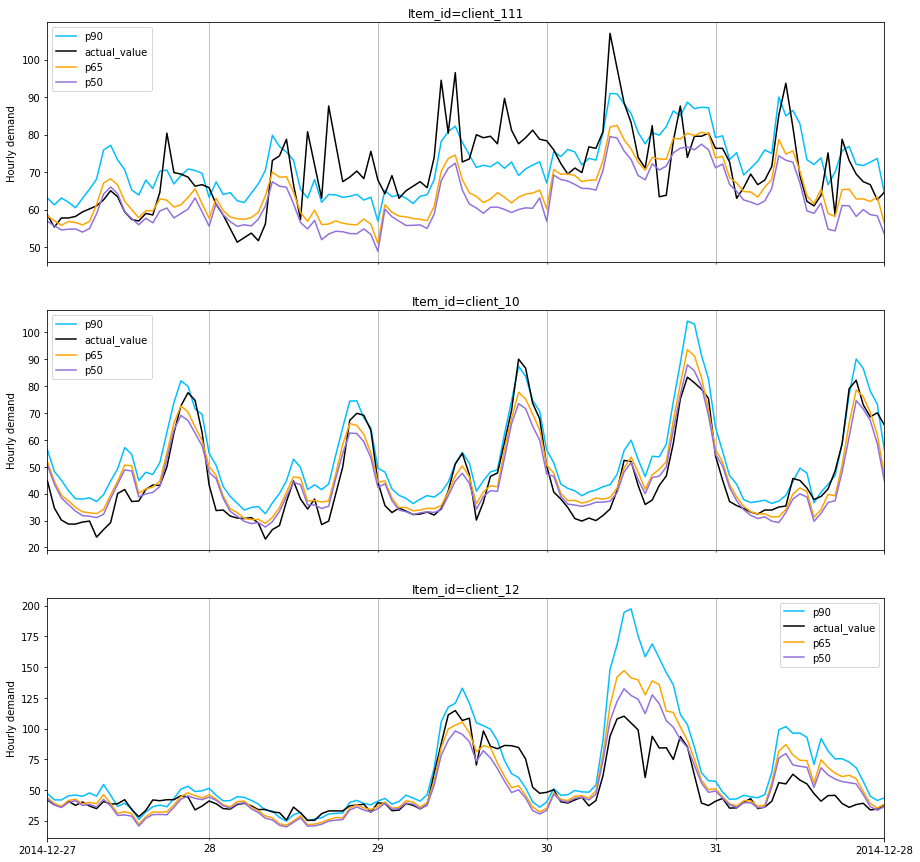

In [248]:
# Visualize items

random_items = df_eligible.item_id.value_counts(dropna=False).index.tolist()
random_items = random.sample(random_items, 3)


np.warnings.filterwarnings('ignore')  #matplotlib in sagemaker kernel is not up to date
fig, axs = plt.subplots(len(random_items), 1, figsize=(15, 15), sharex=True)
axx = axs.ravel()

# gather data for plotting
temp = df_eligible[[item_id, timestamp, target_value, 'p50', 'p65', 'p90']].copy()
# rename "target_value" to "actual_value" for clearer viz
temp.rename(columns={'target_value':'actual_value'}, inplace=True)
temp = temp.groupby([timestamp, item_id]).sum()
temp.reset_index(inplace=True)
temp.set_index(timestamp, inplace=True)


for i in range(len(random_items)):
    
    item = random_items[i]
    zoomed = temp.loc[(temp[item_id]==item), :]
    
    # zoomed-in plots by specific time range if you want
#     zoomed = zoomed['2019-09-05':'2019-09-06']

    zoomed[['p90']].plot(ax=axx[i], color='deepskyblue')
    zoomed[['actual_value']].plot(ax=axx[i], color='k')
    zoomed[['p65']].plot(ax=axx[i], color='orange')
    zoomed[['p50']].plot(ax=axx[i], color='mediumpurple')
            
    axx[i].set_title(f"Item_id={item}")
    axx[i].set_xlabel("")    #date
    axx[i].set_ylabel("Hourly demand")   
    axx[i].grid(which='minor', axis='x')
    axx[i].grid(axis='y')
    axx[i].set_xticklabels([str(dt.date())[0:11] for dt in x[0:-1]])
    axx[i].grid(False)

